### Fix S2 / SiS2 bug
The idea here is to first, modify irene such that:    
1) First she threshold-suppresses the csum waveform    
2) Then she finds the S2s in the threshold-suppressed waveform    
3) Then she passes the chunch of non-suppressed waveform to `rebin_waveform`

Then implement (with this new input) the fix in `rebin_waveform` to avoid the creation of large timebins and ensure that S2 and SiS2 will be properly aligned. 

In [3]:
import os
import tables as tb
import numpy  as np
from matplotlib import pyplot as plt

from invisible_cities.cities.irene  import Irene, IRENE
from invisible_cities.reco.params   import S12Params as S12P
from invisible_cities.core.ic_types import minmax
from invisible_cities.core.system_of_units_c import units
from invisible_cities.reco.pmaps_functions   import load_pmaps
from invisible_cities.reco import peak_functions_c as cpf
from invisible_cities.reco import peak_functions   as  pf
from invisible_cities.io   import pmap_io          as pio

infile = os.path.join(os.environ['IC_DATA'], 
                      'Montecarlo/Co/dst_NEXT_v0_08_09_Co56_INTERNALPORTANODE_0_0_7bar_RWF_10000.root.h5')

with tb.open_file(infile, 'r+') as f:
    print(f)
    nevents = f.root.Run.events.nrows
    event_numbers = f.root.Run.events[:]['evt_number']

/Users/alej/Desktop/IC_DATA/Montecarlo/Co/dst_NEXT_v0_08_09_Co56_INTERNALPORTANODE_0_0_7bar_RWF_10000.root.h5 (File) ''
Last modif.: 'Wed Jun 14 11:06:20 2017'
Object Tree: 
/ (RootGroup) ''
/MC (Group) ''
/MC/FEE (Table(1,)) 'EP-FEE parameters'
/MC/MCTracks (Table(433702,), shuffle, zlib(4)) 'MCTracks'
/RD (Group) ''
/RD/pmtblr (EArray(10000, 12, 48000), shuffle, zlib(4)) ''
/RD/pmtrwf (EArray(10000, 12, 48000), shuffle, zlib(4)) ''
/RD/sipmrwf (EArray(10000, 1792, 1200), shuffle, zlib(4)) ''
/Run (Group) ''
/Run/RunInfo (Table(1,)) 'Run info'
/Run/events (Table(10000,)) 'Events info'



In [4]:
s1par = S12P(time = minmax(min   = 99 * units.mus,
                           max   = 101 * units.mus),
             stride              = 4,
             length = minmax(min = 6,
                             max = 16),
             rebin               = False)

# parameters for s2 searches
s2par = S12P(time = minmax(min   =    101 * units.mus,
                           max   =   1199 * units.mus),
             stride              =     40,
             length = minmax(min =    100,
                             max = 100000),
             rebin               = True)

irene = Irene(run_number  = 0,
                  nprint      = 1,
                  files_in    = [infile],
                  file_out    = 'irene_co_output.h5',
                  compression = 'ZLIB4',
                  n_baseline  = 38000,
                  thr_trigger = 5   * units.adc,
                  n_MAU       = 100,
                  thr_MAU     = 3   * units.adc,
                  thr_csum_s1 = 0.5 * units.pes,
                  thr_csum_s2 = 1.0 * units.pes,
                  n_MAU_sipm  = 100 * units.adc,
                  thr_sipm    = 3.5 * units.pes,
                  s1_params   = s1par,
                  s2_params   = s2par,
                  thr_sipm_s2 = 20)

nevts = 50
#nevt, n_empty_events = irene.run(nmax=nevts)

I want to make the input of `rebin_waveform` be the a chunk of waveform corresponding to the S12, while modifying as little else as possible

#### Modify find_S12 and rebin_waveform

In [5]:
#GENERAL
# The same modifications that the quick fix had,
# exept now rebin waveform works directly with the
# non-suppressed wf, along with start and stop times
# of the S12
def rebin_waveform_fix(ts, t_finish, wf, stride=40):
    """
    Rebin a waveform according to stride
    The input waveform is a vector such that the index expresses time bin and the
    contents expresses energy (e.g, in pes)
    The function returns the rebinned T and E vectors
    NB: This function is used mainly for testing purposed. It is
     programmed "c-style", which is not necesarily optimal
    in python, but follows the same logic that the corresponding cython
    function (in peak_functions_c), which runs faster and should be used
    instead of this one for normal calculations.
    """

    #assert (units.mus / units.ns) % stride == 0
    assert (ts < t_finish)

    
    t_start  = int((ts // (stride*25*units.ns)) * stride*25*units.ns)
    t_total  = t_finish - t_start
    n = int(t_total // (stride*25*units.ns))
    r = int(t_total  % (stride*25*units.ns))
    
    lenb = n
    if r > 0: lenb = n+1

    T = np.zeros(lenb, dtype=np.double)
    E = np.zeros(lenb, dtype=np.double)

    j = 0
    for i in range(n):
        esum  = 0
        for tb in range(int(t_start +  i   *stride*25*units.ns), 
                        int(t_start + (i+1)*stride*25*units.ns), 
                        int(25*units.ns)):
            if tb < ts: continue 
            esum += wf[j]
            j    += 1

        E[i] = esum
        if i == 0: T[0] = (ts + t_start +   stride*25*units.ns) / 2
        else     : T[i] = (     t_start + i*stride*25*units.ns + stride*25*units.ns/2)

    if r > 0:
        esum  = 0
        for tb in range(int(t_start + n*stride*25*units.ns), 
                        int(t_finish), 
                        int(25*units.ns)):
            if tb < ts: continue 
            esum += wf[j]
            j    += 1

        E[n] = esum
        if n == 0: T[n] = (ts + t_finish) / 2
        else     : T[n] = (t_start + n*stride*25*units.ns + t_finish) / 2

    assert j == len(wf)
    return T, E


# CHANGED THE INPUT:
# Got rid of energies and replaced with a waveform of the cumulative pmts.

# Now it finds the start and stop time of the S12 and then send a chunk 
# of the waveform to rebin_waveform (if rebin is set to true)

def find_S12_py_fix(csum, index,
             time   = minmax(0, 1e+6),
             length = minmax(8, 1000000),
             stride=4, rebin=False, rebin_stride=40, default_binsize=25*units.ns):
    """
    Find S1/S2 peaks.
    input:
    csum:   calibrated wf sum of the pmts for an event
    index:   a vector of indices in csum above threshold
    returns a dictionary
    do not interrupt the peak if next sample comes within stride
    accept the peak only if within [lmin, lmax)
    accept the peak only if within [tmin, tmax)
    returns a dictionary of S12
    NB: This function is used mainly for testing purposed. It is programmed
     "c-style", which is not necesarily optimal
    in python, but follows the same logic that the corresponding cython
    function (in peak_functions_c), which runs faster and should be used
    instead of this one for nornal calculations.
    """
    
    T = cpf.time_from_index(index)

    S12  = {}
    S12L = {}

    # Start end end index of S12, [start i, end i) 
    S12[0] = np.array([index[0], index[0] + 1], dtype=np.int32)

    j = 0
    for i in range(1, len(index)) :

        if T[i] > time.max: break
        if T[i] < time.min: continue

        # New s12, create new start and end index
        if index[i] - stride > index[i-1]:  
            j += 1
            S12[j] = np.array([index[i], index[i] + 1], dtype=np.int32)
        
        # Same s12, update end index
        S12[j][1] = index[i] + 1 
    
    j = 0
    for i_peak in S12.values():
        
        if not (length.min <= i_peak[1] - i_peak[0] < length.max):
            continue
            
        S12wf = csum[i_peak[0]: i_peak[1]]
        if rebin == True:
            TR, ER = rebin_waveform_fix(*cpf.time_from_index(i_peak), 
                                        S12wf, 
                                        stride = rebin_stride)
            S12L[j] = [TR, ER]
        else:
            S12L[j] = [np.arange(*cpf.time_from_index(i_peak), default_binsize), S12wf]
        j += 1

    return S12L


# FIXED
Now run Irene by hand to see the results

In [6]:
with tb.open_file(infile ,'r') as f:

    CSUMs  = {}
    S1sc   = {}
    S2sc   = {}
    S2Sisc = {}

    for ev in range(50):
        CSUMs[ev] = irene.calibrated_pmt_sum(irene.deconv_pmt(f.root.RD.pmtrwf[ev]))[0]

        # theshold suppression!
        s1_ene, s1_indx, s2_ene, s2_indx, csum = irene.pmt_transformation(f.root.RD.pmtrwf[ev])

        if np.sum(s2_ene) == 0:
            n_empty_events += 1
            continue

        sipmzs = irene.calibrated_signal_sipm(f.root.RD.sipmrwf[ev])

        # NOW FIND S1, S2, Sii
        S1 = find_S12_py_fix(CSUMs[ev], s1_indx, **irene.s1_params._asdict())
        S2 = find_S12_py_fix(CSUMs[ev], s2_indx, **irene.s2_params._asdict())    
        S1 = irene.correct_S1_ene(S1, csum)
        Si = irene.find_S2Si(S2, sipmzs)
        
        S1sc  [ev] = pio.S12(S1)
        S2sc  [ev] = pio.S12(S2)
        S2Sisc[ev] = pio.S2Si(Si)
    


### 1)  Make sure I haven't messed up the S1s

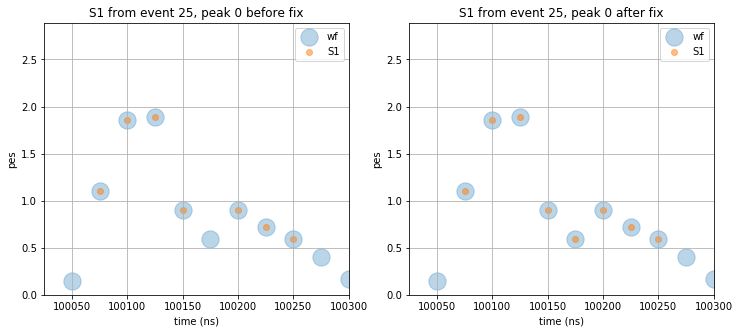

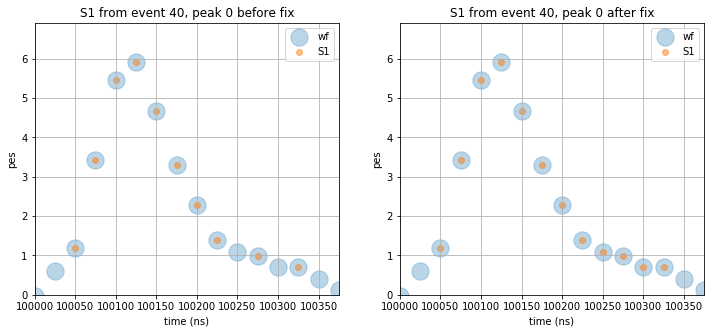

In [7]:
def plot_wvfm_vs_S1(irene, f_rwf, S1p, subplot=-1):
    with tb.open_file(infile, 'r+') as f:
        if subplot != -1:
            plt.subplot(subplot)
        plt.scatter(np.arange(48000) * 25, 
                 irene.calibrated_pmt_sum(irene.deconv_pmt(f.root.RD.pmtrwf[ev]))[0], 
                 label='wf', s=300, alpha=.3)
        plt.scatter(S1p[0] , S1p[1], label='S1',alpha=.5)
        plt.xlim(S1p[0][0] - 50*units.ns, S1p[0][-1] + 50*units.ns)
        plt.ylim(0,S1p[1].max() + 1)
        plt.legend()
        plt.grid(True)
        plt.ylabel('pes')
        plt.xlabel('time (ns)')

# Compare new S1s to old S1s, make sure they are the same but not threshold suppressed.
S1s, S2s, S2Sis = load_pmaps('irene_co_output.h5')

for ev in S1s:
    for p in S1s[ev]:
        
        # S1sc could be shorter due to threshold suppression
        if len(S1s[ev][p][0]) == len(S1sc[ev][p][0]):
            assert np.allclose(S1s[ev][p][0],S1sc[ev][p][0])
            assert np.allclose(S1s[ev][p][1],S1sc[ev][p][1])
            
        # Need to check by hand that this is because old S1s 
        # discarded a below threshold index of waveform
        elif len(S1s[ev][p][0]) < len(S1sc[ev][p][0]):
            plt.figure(figsize=(12,5))
            plot_wvfm_vs_S1(irene, infile, S1s[ev][p] , subplot=121)
            plt.title('S1 from event ' + str(ev) + ', peak ' + str(p) + ' before fix')    
            plot_wvfm_vs_S1(irene, infile, S1sc[ev][p], subplot=122)
            plt.title('S1 from event ' + str(ev) + ', peak ' + str(p) + ' after fix')
            plt.show()
            print('==========================================================================================')
        else: 
            raise ValueError

#### So the S1s are the same except that the new S1s do not threshold suppress any values in any events! **Note this would not have been fixed by the quick fix, modifying only `rebin_waveform`. 

#### Tests for S2s

In [8]:
# THESE SHOULD COVER BUG 1
def test_max_S2_timebin_size(S2s, max_timebin_size=units.mus):
    for S2s_ev in S2s.values(): # event loop
        for S2_p in S2s_ev.values(): # peak loop 
            assert (np.array([S2_p[0][i] - S2_p[0][i-1] \
                     for i in range(1, len(S2_p[0]))])  \
                     <= max_timebin_size).all()

def test_all_middle_timebins_of_same_size(S2s, timebin_size=units.mus):
    """
    All the S2 timebins except the first and last should have the same
    size. Normally 1 microsecond.
    """
    for S2s_ev in S2s.values(): # event loop
        for S2_p in S2s_ev.values(): # peak loop 
            assert (np.array([S2_p[0][i] - S2_p[0][i-1]  \
                     for i in range(2, len(S2_p[0]) -1)])\
                     == timebin_size).all()

In [9]:
# BEFORE
test_max_S2_timebin_size(S2s)

AssertionError: 

In [10]:
# AFTER
test_max_S2_timebin_size(S2sc)

In [11]:
# BEFORE
test_all_middle_timebins_of_same_size(S2s)

AssertionError: 

In [12]:
# AFTER 
test_all_middle_timebins_of_same_size(S2sc)

In [13]:
def test_equal_number_of_timebins_in_S2s_and_S2Sis(S2s, S2Sis):  
    for S2, Si in zip(S2s.values(), S2Sis.values()):
        for p in S2:  
            if p in Si:
                if len(Si[p]) > 0: # Not necessary once Irene run completely with fix
                    assert len(Si[p][next(iter(Si[p]))]) == len(S2[p][0])
                
# SHOULD NOT FAIL FOR EITHER
test_equal_number_of_timebins_in_S2s_and_S2Sis(S2s , S2Sis)
test_equal_number_of_timebins_in_S2s_and_S2Sis(S2sc, S2Sisc)

In [14]:
def test_aligned_S2_and_SiS2_timebins(S2s):
    # TEST ONLY WORKS IN THIS CASE:
    timebin_size = units.mus 
    for S2 in S2s.values():
            for S2_p in S2.values():
                for tb in range(1, len(S2_p[0]) - 1):
                    assert S2_p[0][tb] % timebin_size == 500

In [15]:
# BEFORE
test_aligned_S2_and_SiS2_timebins(S2s)

AssertionError: 

In [16]:
# AFTER
test_aligned_S2_and_SiS2_timebins(S2sc)

In [18]:

### GENERAL
def test_rebin_waveform():
    wf     = np.ones (int(3*units.mus / (25*units.ns)))
    times  = np.arange(0, 3*units.mus,   25*units.ns)
    stride = 40
                                         
    for s in times:
        for f in times[times > s]:
            [T, E] = rebin_waveform_fix(s, f, 
                                      wf[int(s/25): int(f/25)], 
                                      stride=stride)
            
            for i, (t, e) in enumerate(zip(T, E)):
                if i==0:   
                    assert np.isclose(t, 
                            min(np.mean((s, (s // (stride*25*units.ns) + 1)*stride*25*units.ns)), np.mean((f, s))))
                    assert e == min(((s // (stride*25*units.ns) + 1)*stride*25*units.ns - s) / 25*units.ns, 
                                    (f - s) / (25*units.ns))
                elif i < len(T) - 1:
                    assert np.isclose(t, np.ceil(T[i-1]/(stride*25*units.ns))*stride*25*units.ns + stride * 25*units.ns / 2)
                    assert e == stride
                else:
                    assert i == len(T) - 1
                    assert np.isclose(t, np.mean((np.ceil(T[i-1] / (stride*25*units.ns))*stride*25*units.ns, f)))
                    assert e == (f - np.ceil(T[i-1] / (stride*25*units.ns)) * stride*25*units.ns) / (25*units.ns)
                    
#%timeit test_rebin_waveform() 
test_rebin_waveform()